# **LLM Zoomcamp 2024 Competition**
### **Author:  [🅱🅻🅰🆀 ](https://www.linkedin.com/in/chinonsoodiaka/)**


Welcome to my submission for the [LLM Zoomcamp 2024 Competition](https://www.kaggle.com/competitions/llm-zoomcamp-2024-competition/overview) hosted by [DataTalksClub](https://datatalks.club/). This notebook showcases an innovative approach to solving complex mathematics problems using Large Language Models (LLMs).



TL;DR: Three-Pronged Approach


**1.) LLMMathChain by Langchain**: Utilizing a specialized chain developed by the Langchain community for mathematical problem-solving.

**2.) Query Restructuring**: Enhancing problem-solving capabilities by transforming user queries into *Python numerical expressions* before processing.

**3.) Retrieval-Augmented Generation (RAG)**: Implementing BM25, a sparse database system, to create an "episodic memory" for the agent, significantly boosting its problem-solving prowess.

The third step above is inspired by cutting-edge research in the field:  [link to paper](https://arxiv.org/html/2404.10952v1)


While LLMs are still evolving in their ability to autonomously solve complex mathematical problems, my approach represents a significant step forward in this domain.



To begin, I'll set up my environment by installing the necessary requirements. Let's do this:

### **Before we begin**

To start it off, I installed the necessary python packages:

I made use of [Openai](https://platform.openai.com/playground/chat?models=gpt-4o) and [Anthropic](https://console.anthropic.com/workbench/3c0bb5b7-b460-4cec-a3f6-b7eeb2eec470) models. These are paid models so ensure to have an account with them and some credits if you will be running this notebook.

In [38]:
!pip install -qU langchain-openai langchain langchain_community langchain-anthropic langchainhub langgraph

Then I imported the libraries that I needed from those packages..

In [17]:
from langchain_openai import OpenAI, ChatOpenAI
from langchain.chains import LLMMathChain, LLMChain
from langchain.prompts import PromptTemplate
from langchain.agents.agent_types import AgentType
from langchain.agents import Tool, initialize_agent

I sent my *api keys* to the environment. This notebook was created on Google Colab so I used *userdata.get()*

In [2]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')

# Or use getpass
#def _get_env(var: str):
#    if not os.environ.get(var):
#        os.environ[var] = getpass.getpass(f"{var}: ")


#_get_env("ANTHROPIC_API_KEY")
#_get_env("LANGCHAIN_API_KEY")
#os.environ["LANGCHAIN_TRACING_V2"] = "true"

Then I set up Langsmith for tracing. Get started with Langsmith [here](https://smith.langchain.com/o/f2adffe6-d93b-5c6f-9047-1174f7260035/projects/p/2a218c21-a946-41ed-9b3d-73a3d573081f?timeModel=%7B%22duration%22%3A%227d%22%7D).

In [259]:
import os
from uuid import uuid4


unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
print("-"*40)
os.environ["LANGCHAIN_PROJECT"] = f"LLM Zoomcamp 2024 Kaggle Competition - {unique_id}"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
print("Langsmith setup completed!")

----------------------------------------
Langsmith setup completed!


### **LLMMathChain**

Now I started experimenting with my design and its components.

First, I tried this custom chain - [LLMMathChain](https://api.python.langchain.com/en/latest/_modules/langchain/chains/llm_math/base.html). I used *gpt-3.5-turbo-instruct* an [Openai legacy model](https://platform.openai.com/docs/models/gpt-3-5-turbo-instruct).

In [6]:
llm = OpenAI(model= "gpt-3.5-turbo-instruct", temperature=0)

In [7]:
# templates
math_template = "Useful for when you need to answer questions about math. This tool is only for math questions and nothing else. Only input math expressions."

word_problem_template = """You are a reasoning agent tasked with solving
the user's logic-based questions. Logically arrive at the solution, and be
factual. In your answers, clearly detail the steps involved and give the
final answer. Provide the response in bullet points.
Question: {question}

Thought: Consider converting the equation into a numerical format suitable for calculation.
Action: Perform the calculation using the Calculator tool.
Action Input: The numerical equation obtained from the conversion step.
Observation: The result of the calculation.

Thought: I now know the final answer.
Final Answer: The final numerical solution to the original input question."""

In [14]:
# Tools
llm_math_chain = LLMMathChain.from_llm(llm=llm, verbose=True)
math_tool = Tool.from_function(
        func=llm_math_chain.run,
        name="Calculator",
        description=math_template,
    )

reasoning_prompt = PromptTemplate(input_variables=["question"],
                                       template=word_problem_template
                                       )
word_problem_chain = LLMChain(llm=llm,
                              prompt=reasoning_prompt)
word_problem_tool = Tool.from_function(name="Reasoning Tool",
                                       func=word_problem_chain.run,
                                       description="Useful for when you need \n"
"to answer logic-based/reasoning questions.",
                                    )

tools = [math_tool, word_problem_tool]

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


Now, I have two tools. I have a math tool for math problems, and a logic reasoning tool for logic questions. If you go through the example questions in the [datasets](https://www.kaggle.com/competitions/llm-zoomcamp-2024-competition/data) provided by the competition's host on Kaggle, you will find that these two tools of mine pretty much can cover more than 70% of the questions. So a very good place to start.

To use these tools, I need some form of automation/function. This will enable me successfully route questions to the appropriate tool. For this, I used a *Zero-shot-react-agent*. You can find out more about it [here](https://python.langchain.com/v0.1/docs/modules/agents/agent_types/react/).

In [18]:
PREFIX = """You are a world-class competitive programmer.
Answer the following questions as best you can. Use the tools you have. Follow these steps:

1. Identify the variables and constants in the problem.
2. Define the calculations using Python code.
3. Use Python's numerical libraries to evaluate the expressions.
4. Provide the final answer based on the evaluated expressions."""

FORMAT_INSTRUCTIONS = """Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of: Calculator, Reasoning Tool
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat ONLY 1 time)
Thought: I now know the final answer
Final Answer: the final answer to the original input question"""
SUFFIX = """Begin!

Question: {input}
Thought:{agent_scratchpad}"""

agent = initialize_agent(
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=7,
    handle_parsing_errors=True,
    agent_kwargs={
        'prefix':PREFIX,
        'format_instructions':FORMAT_INSTRUCTIONS,
        'suffix':SUFFIX
    }
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.3.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


Alright. My agent is ready.

Try it:

In [20]:
problem_input = input()  # Find the value of the expression \(4.8 \cdot 2.5\).

print(agent.invoke({"input": problem_input}))

Find the value of the expression \(4.8 \cdot 2.5\).


> Entering new AgentExecutor chain...
 I should use a calculator to evaluate this expression.
Action: Calculator
Action Input: 4.8 * 2.5

> Entering new LLMMathChain chain...
4.8 * 2.5```text
4.8 * 2.5
```
...numexpr.evaluate("4.8 * 2.5")...

Answer: 12.0
> Finished chain.

Observation: Answer: 12.0
Thought: I now know the final answer.
Final Answer: 12.0

> Finished chain.
{'input': 'Find the value of the expression \\(4.8 \\cdot 2.5\\).', 'output': '12.0'}


I tried this manually. I prompted my agent with each of the 100 questions in the test.csv dataset on Kaggle, and my score after submission was **0.375**.

Then I switched from a legacy model to a chat completions model like gpt-4 (**gpt-4o-2024-05-13**) and my score became **0.725**.

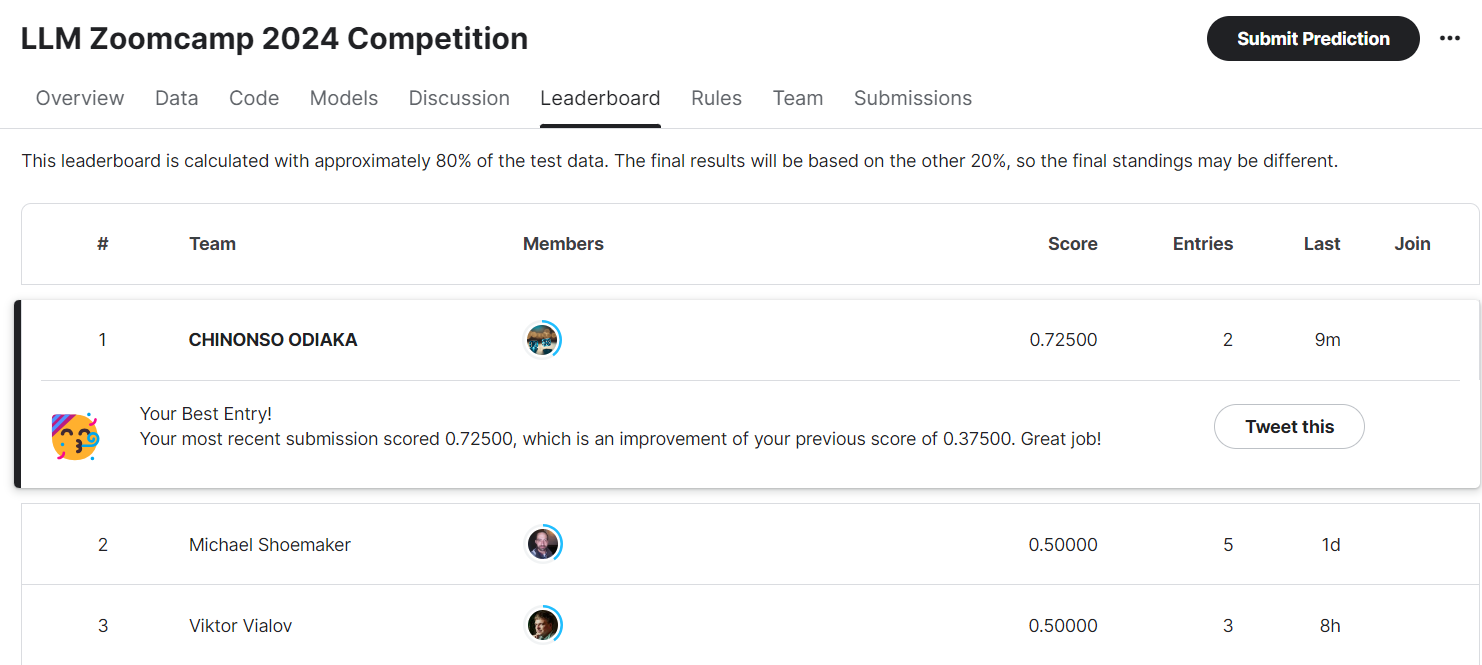

NB:For the questions that it coud not answer and raised an error, I just filled up with the value **2** because you could not have nulls in your submission.csv

Next: I found out that my math tool throws an error for calculations involving variables like *x*. LLMMathChain throws an error for inputs wth non numerical variables.

For example, **Solve the equation \( x^{2} + 4x = 0 \). If the equation has more than one root, indicate the smaller one in the answer** will raise an error.

Therefore, I decided that my next strategy was to have two agents: one agent, the *solver*, will restructure each query in *python numerical expressions* before it solves the query in python. Then it passes its output to the *generator* whose job is to answer the query with the solver's output as context.

NB: The purpose of *python numerical expressions* is to avoid the errors I got using the chain.

## **Query restructuring**

Second, I tried *claude-3-5-sonnet-20240620*; the smartest model that Anthropic has till date (2024-06-24), to restructure the question from math into python code.

Here I defined the state:

In [260]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    # Append-only chat memory so the agent can try to recover from initial mistakes.
    messages: Annotated[list[AnyMessage], add_messages]


Then I created the chains:

In [261]:
from langchain_core.language_models import BaseChatModel
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain import hub
from langchain_anthropic import ChatAnthropic
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain, SimpleSequentialChain, SequentialChain

In [262]:
from langchain_openai import OpenAI, ChatOpenAI

In [263]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

class writePython(BaseModel):
    reasoning: str = Field(..., description="Conceptual solution.")
    pseudocode: str = Field(..., description="Detailed English pseudocode.")
    code: str = Field(..., description="Valid Python 3 solution to the problem")

class Solver:
    def __init__(self, llm: BaseChatModel, prompt: ChatPromptTemplate):
        self.runnable = prompt | llm.bind_tools([writePython])

    def __call__(self, state: State) -> dict:
        return {"messages": [self.runnable.invoke({"messages": state["messages"]})]}

# Initialize LLM and prompt
prompt = hub.pull("wfh/usaco-draft-solver").partial(examples="")
llm = ChatAnthropic(model='claude-3-5-sonnet-20240620',temperature=0)
#llm = ChatOpenAI(model_name="gpt-4o-2024-05-13", temperature=0)
solver = Solver(llm, prompt)

# Create a prompt template for the answer generation
answer_prompt_template = PromptTemplate(
    input_variables=["question", "context"],
    template="""
Question: {question}

Context (Solver Output):
{context}

Based on the context provided above, which is the output from a problem solver, please answer the original question. Be concise and provide only the specific answer without any additional explanation.

Answer:
"""
)

# Create a prompt template for the solver
solver_prompt_template = PromptTemplate(
    input_variables=["question"],
    template="Solve the following problem:\n\n{question}\n\nProvide a detailed solution."
)

# Create the solver chain
solver_chain = LLMChain(llm=llm, prompt=solver_prompt_template, output_key="solution")

# Create a prompt template for the answer generation
answer_prompt_template = PromptTemplate(
    input_variables=["question", "solution"],
    template="""
Question: {question}

Solution:
{solution}

Based on the solution provided above, please answer the original question. Be concise and provide only the specific answer without any additional explanation.

Answer:
"""
)

# Create the answer generation chain
answer_chain = LLMChain(llm=llm, prompt=answer_prompt_template, output_key="answer")

# Combine the chains
generator_chain = SequentialChain(
    chains=[solver_chain, answer_chain],
    input_variables=["question"],
    output_variables=["solution", "answer"]
)



Now test my generator chain:

In [264]:
# Example usage
problem_input = """
Find a four-digit number that is 11 times smaller than the cube of a certain natural number. In your answer, provide any one such number.
"""

result = generator_chain({"question": problem_input})
print(f"Question: {problem_input}")
print(f"Solution: {result['solution']}")
print(f"Answer: {result['answer']}")

Question: 
Find a four-digit number that is 11 times smaller than the cube of a certain natural number. In your answer, provide any one such number.

Solution: Let's approach this problem step by step:

1) Let's say the natural number we're looking for is n.

2) The four-digit number we're seeking is (n³ ÷ 11).

3) For this to be a four-digit number, it must be between 1000 and 9999.

4) So, we can set up the inequality:
   1000 ≤ (n³ ÷ 11) < 10000

5) Multiplying all parts by 11:
   11000 ≤ n³ < 110000

6) Taking the cube root of all parts:
   ³√11000 ≤ n < ³√110000
   22.14 ≤ n < 48.07

7) Since n is a natural number, this means n could be 23, 24, 25, ..., up to 48.

8) Let's try n = 23:
   23³ = 12167
   12167 ÷ 11 = 1106.09 (not an integer)

9) Let's try n = 24:
   24³ = 13824
   13824 ÷ 11 = 1256 (This works!)

Therefore, one solution is 1256, which is 11 times smaller than 24³.

We can verify:
24³ = 13824
13824 ÷ 11 = 1256
1256 × 11 = 13824 = 24³

So, 1256 is a valid answer to th

After manually testing the 100 questions in the test.csv file, my score was **87.5**.

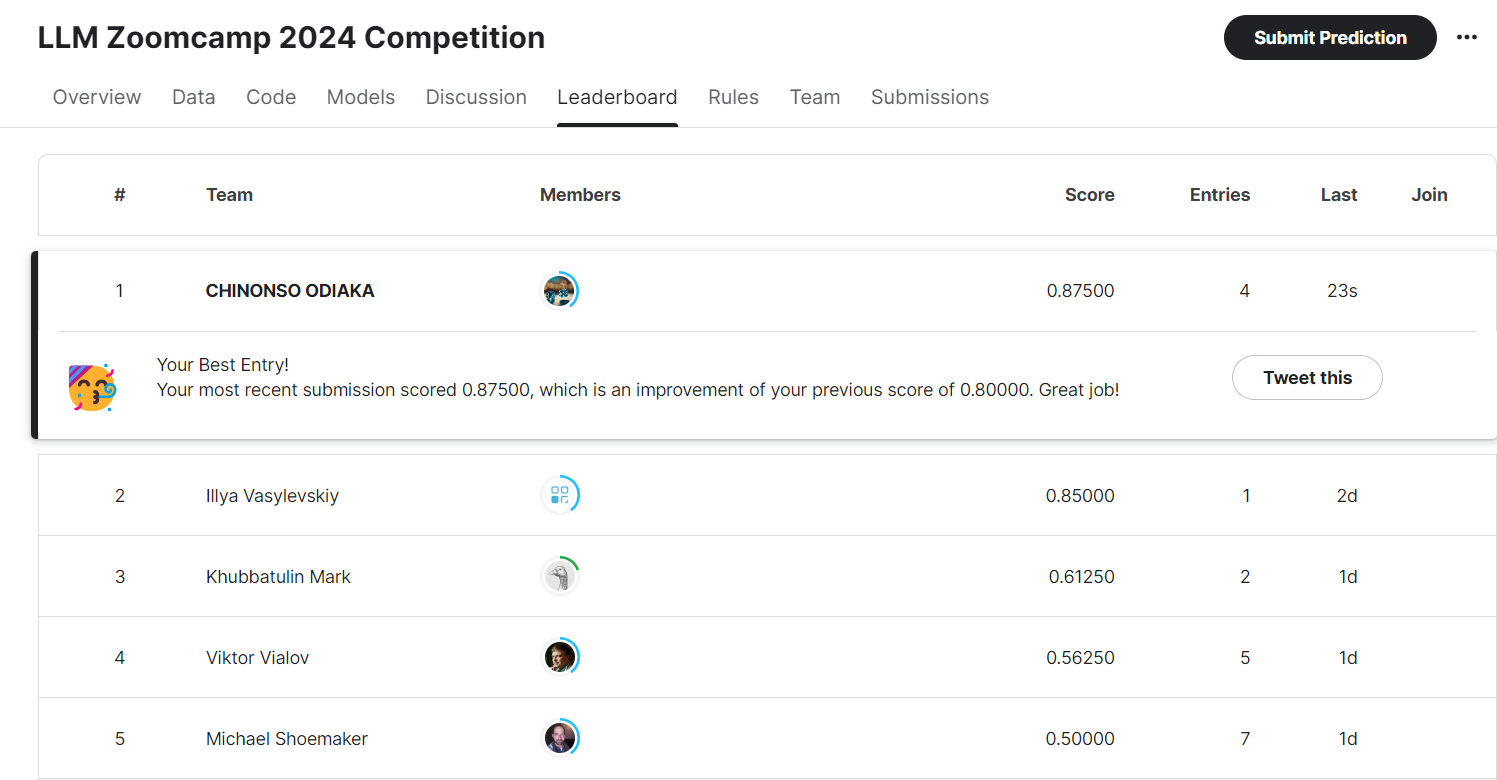

My final approach involved implementing a Retrieval-Augmented Generation (RAG) technique. This step was crucial in addressing the limitations observed in Step 2 above, where I often caught my agent hallucinating and completely wrong.

So I created an Enhanced dataset leveraging Langsmith, Langchain's tracing tool, and was able to generate a new, more comprehensive training dataset. Unlike the original train.csv provided on Kaggle, which only contained answers, my enhanced dataset included detailed reasoning, solutions, and step-by-step workings for each problem. I got this by manually prompting GPT-4 to answer each of the 100 questions in the train.csv file, and I captured this via Langsmith, and then generated a dataset from these.

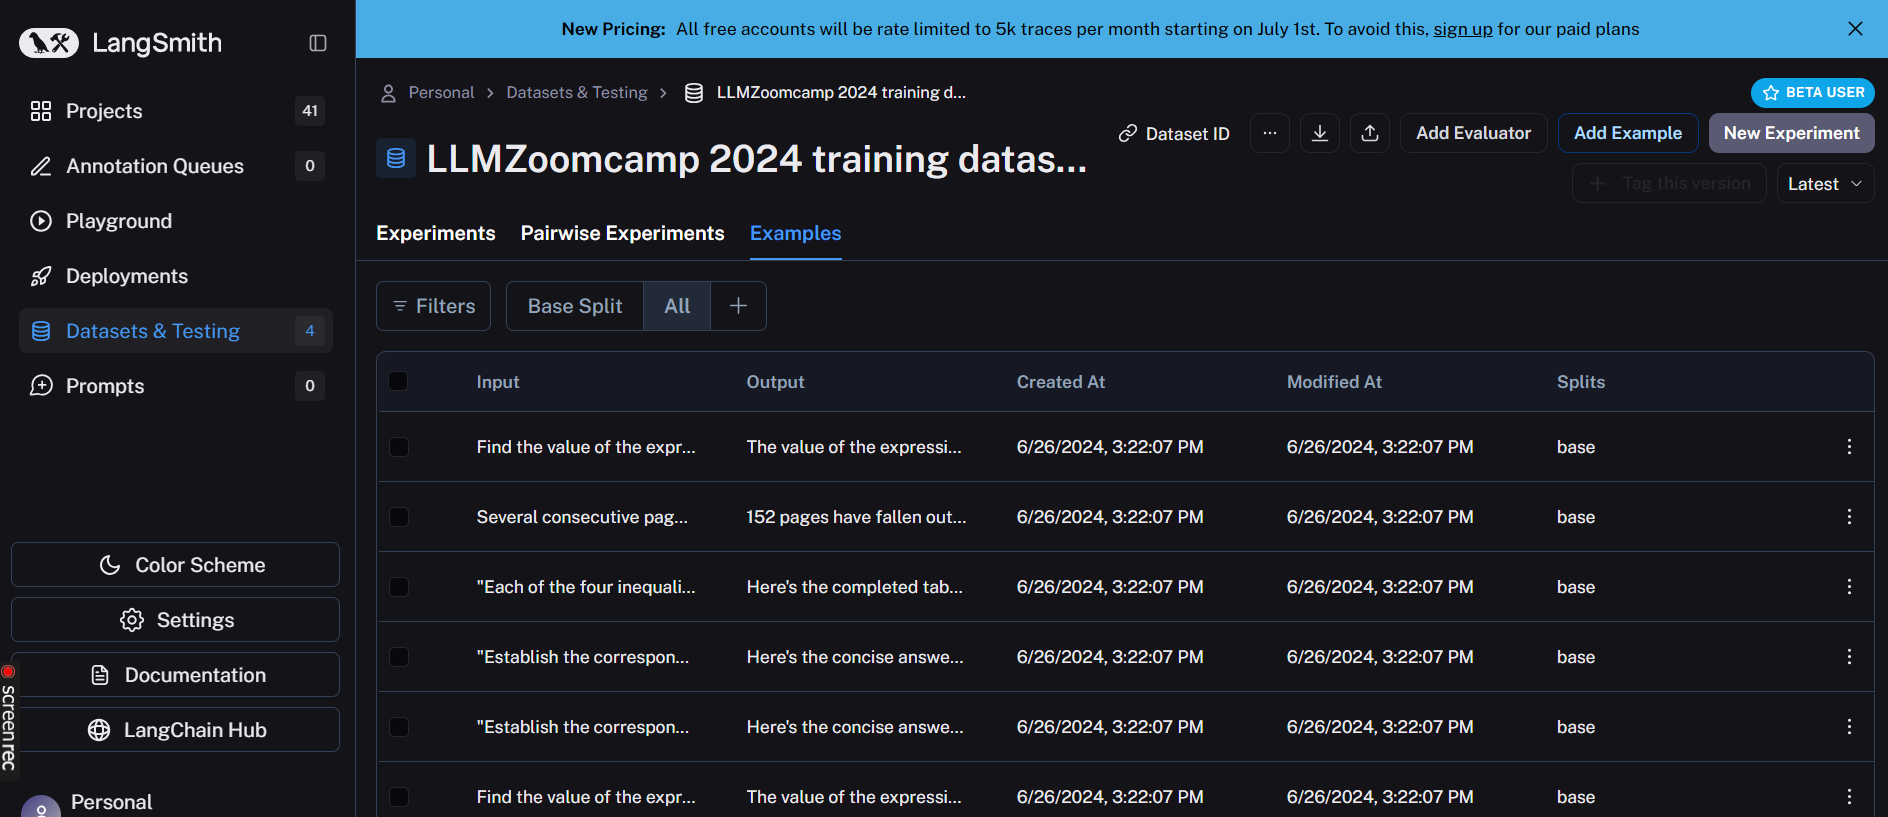

With this enganced dataset, I developed a technique to create a database of exemplar solutions. This database serves as a rich context source for my agent when faced with new questions. The idea was to provide relevant, similar problem-solving approaches as reference material to guide the agent's reasoning process.

Alternatively, you can uncomment and run the code block below if you did not use Langsmith.

In [265]:
# Load your dataset
#df = pd.read_csv('/content/train.csv')  # Replace with your actual dataset path

# Function to process each question
#def process_question(question):
#    result = generator_chain({"question": question})
#    return result["solution"], result["answer"]

# Create empty lists to store the results
#solutions = []
#answers = []

# Iterate over each problem_text in the DataFrame
#for index, row in df.iterrows():
#    question = row['problem_text']
#    solution, answer = process_question(question)
#    solutions.append(solution)
#    answers.append(answer)
#    print(f"Processed question {index+1}/{len(df)}")

# Add solutions and answers to the DataFrame
#df['solution'] = solutions
#df['answer'] = answers

# Save the results to a new CSV file
#df.to_csv('processed_problems.csv', index=False)

#print("Processing complete. Results saved to 'processed_problems.csv'.")

Processed question 1/100
Processed question 2/100
Processed question 3/100
Processed question 4/100
Processed question 5/100
Processed question 6/100
Processed question 7/100
Processed question 8/100
Processed question 9/100
Processed question 10/100
Processed question 11/100
Processed question 12/100
Processed question 13/100
Processed question 14/100
Processed question 15/100
Processed question 16/100
Processed question 17/100
Processed question 18/100
Processed question 19/100
Processed question 20/100
Processed question 21/100
Processed question 22/100
Processed question 23/100
Processed question 24/100
Processed question 25/100
Processed question 26/100
Processed question 27/100
Processed question 28/100
Processed question 29/100
Processed question 30/100
Processed question 31/100
Processed question 32/100
Processed question 33/100
Processed question 34/100
Processed question 35/100
Processed question 36/100
Processed question 37/100
Processed question 38/100
Processed question 39

### **RAG with BM25**

As I said before, during the implementation of step 2 (Query Restructuring), I noticed that the agent often struggled with highly complex questions, frequently producing confident but incorrect answers. This observation highlighted the need to tackle the issue of LLM hallucinations - a challenge I was well prepared for thanks to the training received in the [LLM Zoomcamp course](https://github.com/DataTalksClub/llm-zoomcamp/tree/main).

By incorporating this RAG technique, I aimed to ground the model's responses in verified, relevant information, thereby reducing the likelihood of hallucinations and improving the overall accuracy and reliability of my agent.

In [3]:
! pip install -qU rank_bm25

In [266]:
import pandas as pd
from rank_bm25 import BM25Okapi
from langchain import PromptTemplate
from langchain.chains import LLMChain, SimpleSequentialChain, SequentialChain
from langchain_anthropic import ChatAnthropic

In [267]:
import pandas as pd

df = pd.read_csv('/content/test.csv')
df.head()

,problem_id,problem_text
0,11919,Find the value of the expression \(4.8 \cdot 2...
1,8513,The plane's navigation system informs the pass...
2,7887,The volume of a rectangular parallelepiped is ...
3,5272,Find the root of the equation: $\left(\dfrac{1...
4,8295,"At the school, there are two-person camping te..."


In [12]:
df['input_question'] = df['input_question'].astype(str)

In [268]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.language_models import BaseChatModel
from langchain_core.prompts import ChatPromptTemplate

In [225]:
# Initialize BM25
tokenized_corpus = [doc.split(" ") for doc in df['input_question']]
bm25 = BM25Okapi(tokenized_corpus)

def retrieve_similar_questions(new_question, top_k=3):
    tokenized_query = new_question.split(" ")
    doc_scores = bm25.get_scores(tokenized_query)
    top_k_indices = doc_scores.argsort()[-top_k:][::-1]
    return df.iloc[top_k_indices]

class writePython(BaseModel):
    """Write python code that resolves the problem."""
    reasoning: str = Field(..., description="Conceptual solution.")
    pseudocode: str = Field(..., description="Detailed English pseudocode.")
    code: str = Field(..., description="Valid Python 3 solution to the problem")

class ContextualGenerator:
    def __init__(self, llm: BaseChatModel, prompt_template: ChatPromptTemplate):
        self.llm = llm
        self.prompt_template = prompt_template

    def generate(self, new_question, similar_context):
        prompt = self.prompt_template.format(question=new_question, context=similar_context)
        return self.llm.predict(prompt)

# Initialize the LLM
llm = ChatAnthropic(model='claude-3-5-sonnet-20240620', temperature=0)

# Create a prompt template for the generator
generator_prompt_template = PromptTemplate(
    input_variables=["question", "context"],
    template="""
Given the following similar questions and their solutions:

{context}

Answer the new question:

Question: {question}
"""
)

# Initialize the contextual generator
generator = ContextualGenerator(llm, generator_prompt_template)

def format_similar_context(similar_questions):
    context = ""
    for i, row in similar_questions.iterrows():
        context += f"Question: {row['input_question']}\n"
        context += f"Solution: {row['output_solution']}\n\n"
    return context.strip()

In [248]:
question = """
Cross out three digits in the number 14563743 so that the resulting number is divisible by 22. In the answer, indicate any one resulting number.
"""

In [249]:
# usage
new_question = question
similar_questions = retrieve_similar_questions(new_question)
similar_context = format_similar_context(similar_questions)

generated_answer = generator.generate(new_question, similar_context)
print(generated_answer)

Let's approach this step-by-step:

1) First, recall the divisibility rule for 22:
   A number is divisible by 22 if it's divisible by both 11 and 2.

2) For divisibility by 2, the last digit must be even (0, 2, 4, 6, or 8).

3) For divisibility by 11, the alternating sum of digits should be divisible by 11. 
   (First digit - second digit + third digit - fourth digit and so on)

4) We need to cross out 3 digits, leaving us with 5 digits.

5) Let's start by ensuring the number is even. We can keep the last digit (3) or use the 4 or 6 from earlier in the number.

6) Now, let's try some combinations, focusing on making the alternating sum divisible by 11:

   14563743 → 14743 (1-4+7-4+3 = 3, not divisible by 11)
   14563743 → 15643 (1-5+6-4+3 = 1, not divisible by 11)
   14563743 → 16743 (1-6+7-4+3 = 1, not divisible by 11)
   14563743 → 56743 (5-6+7-4+3 = 5, not divisible by 11)
   14563743 → 15374 (1-5+3-7+4 = -4, which is divisible by 11)

7) We've found a solution: 15374

8) Let's ver

In [269]:


# Load your datasets
processed_problems = pd.read_csv('processed_problems.csv')
test_problems = pd.read_csv('test.csv')

# Initialize BM25 with the processed problems
tokenized_corpus = [doc.split(" ") for doc in processed_problems['problem_text']]
bm25 = BM25Okapi(tokenized_corpus)

def retrieve_similar_questions(new_question, top_k=3):
    tokenized_query = new_question.split(" ")
    doc_scores = bm25.get_scores(tokenized_query)
    top_k_indices = doc_scores.argsort()[-top_k:][::-1]
    return processed_problems.iloc[top_k_indices]

class writePython(BaseModel):
    """Write python code that resolves the problem."""
    reasoning: str = Field(..., description="Conceptual solution.")
    pseudocode: str = Field(..., description="Detailed English pseudocode.")
    code: str = Field(..., description="Valid Python 3 solution to the problem")

class ContextualGenerator:
    def __init__(self, llm: BaseChatModel, prompt_template: ChatPromptTemplate):
        self.llm = llm
        self.prompt_template = prompt_template

    def generate(self, new_question, similar_context):
        prompt = self.prompt_template.format(question=new_question, context=similar_context)
        return self.llm.predict(prompt)

# Initialize the LLM
llm = ChatAnthropic(model='claude-3-5-sonnet-20240620', temperature=0)

# Create a prompt template for the generator
generator_prompt_template = PromptTemplate(
    input_variables=["question", "context"],
    template="""
Given the following similar questions and their solutions:

{context}

Answer the new question:

Question: {question}
"""
)

# Initialize the contextual generator
generator = ContextualGenerator(llm, generator_prompt_template)

def format_similar_context(similar_questions):
    context = ""
    for i, row in similar_questions.iterrows():
        context += f"Question: {row['problem_text']}\n"
        context += f"Solution: {row['solution']}\n\n"
    return context.strip()

# Process each problem in the test dataset
results = []

for index, row in test_problems.iterrows():
    new_question = row['problem_text']
    similar_questions = retrieve_similar_questions(new_question)
    similar_context = format_similar_context(similar_questions)

    generated_answer = generator.generate(new_question, similar_context)
    results.append({
        'problem_id': row['problem_id'],
        'problem_text': new_question,
        'generated_solution': generated_answer
    })
    print(f"Processed problem {index + 1}/{len(test_problems)}")

# Convert results to a DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('generated_solutions.csv', index=False)

print("Processing complete. Results saved to 'generated_solutions.csv'.")


Processed problem 1/100
Processed problem 2/100
Processed problem 3/100
Processed problem 4/100
Processed problem 5/100
Processed problem 6/100
Processed problem 7/100
Processed problem 8/100
Processed problem 9/100
Processed problem 10/100
Processed problem 11/100
Processed problem 12/100
Processed problem 13/100
Processed problem 14/100
Processed problem 15/100
Processed problem 16/100
Processed problem 17/100
Processed problem 18/100
Processed problem 19/100
Processed problem 20/100
Processed problem 21/100
Processed problem 22/100
Processed problem 23/100
Processed problem 24/100
Processed problem 25/100
Processed problem 26/100
Processed problem 27/100
Processed problem 28/100
Processed problem 29/100
Processed problem 30/100
Processed problem 31/100
Processed problem 32/100
Processed problem 33/100
Processed problem 34/100
Processed problem 35/100
Processed problem 36/100
Processed problem 37/100
Processed problem 38/100
Processed problem 39/100
Processed problem 40/100
Processed

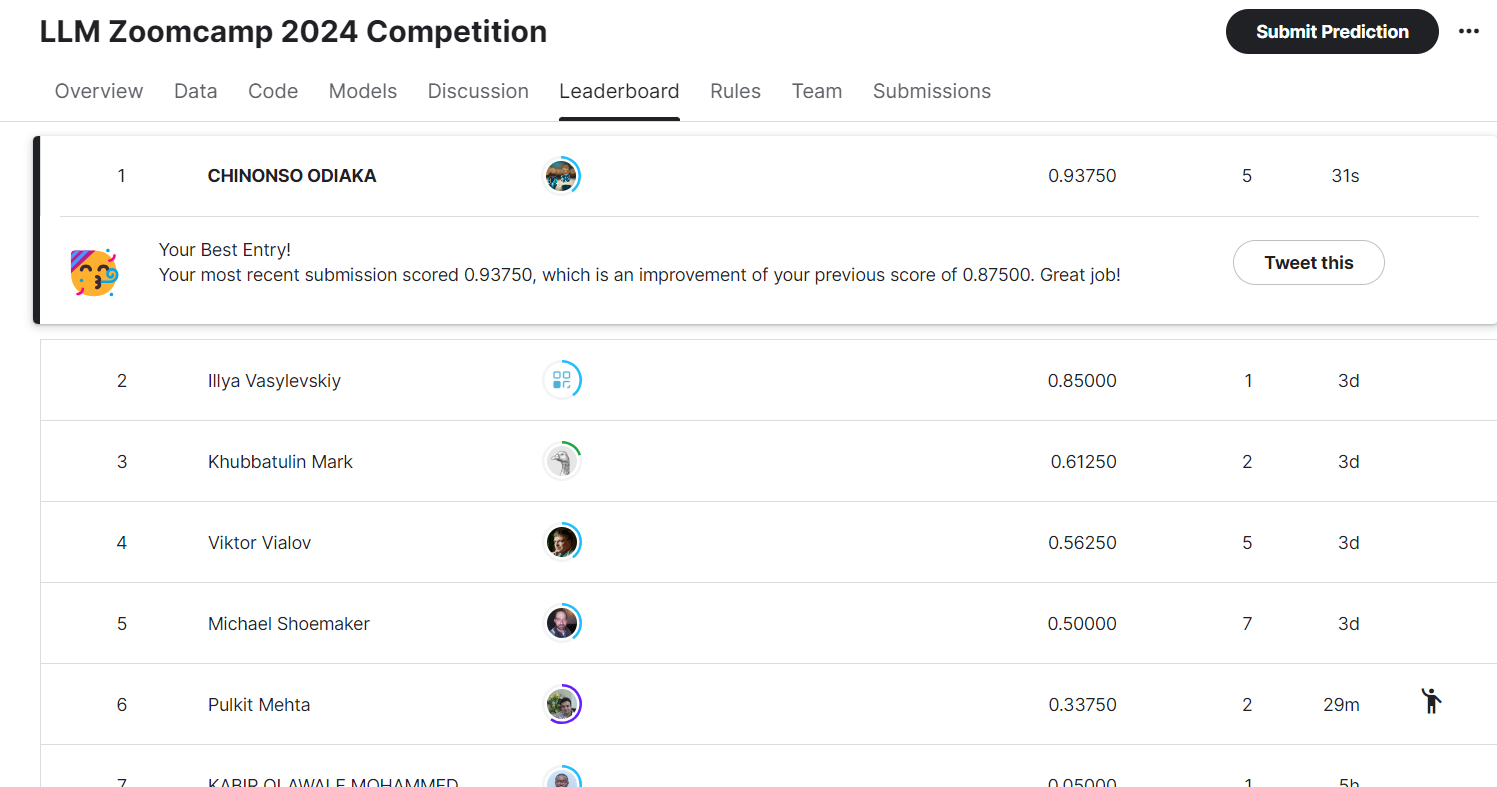

## Conclusion


LLMs are not capable of solving all these problems autonomously, but through better prompting and clever engineering, you can create a system that is able to more reliably arrive at the proper solution.